In [50]:
import geopandas as gpd
import folium
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
from shapely.geometry import Polygon

root = "C://Users//user//Desktop//Helmholtz//Tasks//Task 1//"


def get_all_basin_coords():
    basins_dir = "Basin_Boundaries//"
    #basin_file_names = [f for f in listdir(join(root, basins_dir)) if isfile(join(root, basins_dir, f))]
    # below basins are present in mopex dataset
    basin_file_names = ["01048000.BDY", "01055500.BDY","01060000.BDY"]
    
    m = folium.Map(zoom_start=10, tiles='cartodbpositron')
    
    all_basin_geoms = []
    for file_name in basin_file_names[:]:
        lat_point_list = []
        lon_point_list = []
        df = pd.read_csv(join(root, basins_dir, file_name), delim_whitespace=True, header=None, skiprows=1)
        lat_point_list = df[1]
        lon_point_list = df[0]
    
        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        all_basin_geoms.append(polygon_geom)
         
    return all_basin_geoms

 
def read_prism_hdr(hdr_path):
    """Read an ESRI BIL HDR file"""
    with open(hdr_path, 'r') as input_f:
        header_list = input_f.readlines()
    return dict(item.strip().split() for item in header_list)
 
def read_prism_bil(bil_path):
    """Read an array from ESRI BIL raster file"""
    hdr_dict = read_prism_hdr(bil_path.replace('.bil', '.hdr'))
    
    prism_array = np.fromfile(bil_path, dtype=np.float32)
    prism_array = prism_array.reshape(
        int(hdr_dict['NROWS']), int(hdr_dict['NCOLS']))
    prism_array[prism_array == float(hdr_dict['NODATA'])] = np.nan
    return prism_array

def get_ppt_data(year,month):
    prism_dir = "PRISM_ppt_stable_4kmM3_198101_202001_bil//"
    if(month<10):
        prism_file_path = "PRISM_ppt_stable_4kmM3_"+str(year)+"0"+str(month)+"_bil.bil"
    else:
        prism_file_path = "PRISM_ppt_stable_4kmM3_"+str(year)+str(month)+"_bil.bil"    
    ppt_data = read_prism_bil(join(root, prism_dir, prism_file_path))
    
    hdr_dict = read_prism_hdr(join(root, prism_dir, prism_file_path).replace('.bil', '.hdr'))
    
    hdr_dict["ULXMAP"] = float(hdr_dict["ULXMAP"])
    hdr_dict["ULYMAP"] = float(hdr_dict["ULYMAP"])
    hdr_dict['NROWS'] = int(hdr_dict['NROWS'])
    hdr_dict['NCOLS'] = int(hdr_dict['NCOLS'])
    hdr_dict['XDIM'] = float(hdr_dict['XDIM'])
    hdr_dict['YDIM'] = float(hdr_dict['YDIM'])
    
    p1 = (hdr_dict["ULXMAP"] - (hdr_dict['XDIM']/2), 
          hdr_dict["ULYMAP"] + (hdr_dict['XDIM']/2))

    p2 = (hdr_dict["ULXMAP"] + hdr_dict['NCOLS']*hdr_dict['XDIM'],
          hdr_dict["ULYMAP"] + (hdr_dict['XDIM']/2))

    p3 = (hdr_dict["ULXMAP"] + hdr_dict['NCOLS']*hdr_dict['XDIM'],
          hdr_dict["ULYMAP"] - hdr_dict['NROWS']*hdr_dict['YDIM'])

    p4 = (hdr_dict["ULXMAP"] - (hdr_dict['XDIM']/2),
          hdr_dict["ULYMAP"] - hdr_dict['NROWS']*hdr_dict['YDIM'])
    
    lon_point_list = (p1[0], p2[0], p3[0], p4[0])
    lat_point_list = (p1[1], p2[1], p3[1], p4[1])
        
    ppt_bounds = Polygon(zip(lon_point_list, lat_point_list))
    
    return ppt_bounds, ppt_data, hdr_dict

def convert_pptData_to_GDF(ppt_bounds, ppt_data, hdr_dict): 
    Xmin, Ymin, Xmax, Ymax = ppt_bounds.bounds
    
    Xlength = int((Xmax - Xmin)/hdr_dict['XDIM'])
    Ylength = int((Ymax - Ymin)/hdr_dict['YDIM'])
    
    xx, yy = np.meshgrid(np.linspace(Xmin, Xmax, Xlength), np.linspace(Ymin, Ymax, Ylength))
    xc = xx.flatten()
    yc = yy.flatten()
    ppt_data = ppt_data.flatten()
    
    df = pd.DataFrame(
        {'Precipitation': ppt_data,
         'Latitude': yc,
         'Longitude': xc})
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    return gdf

In [57]:
def plot_basins(basin_geoms):
    crs = {'init': 'epsg:4326'}
    m = folium.Map(zoom_start=10, tiles='cartodbpositron')

    for basin_geom in basin_geoms:
        polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[basin_geom])       

        folium.GeoJson(polygon).add_to(m)
        folium.LatLngPopup().add_to(m)
        
    return m

In [53]:
all_basin_geoms = get_all_basin_coords()
ppt_bounds, ppt_data, hdr_dict = get_ppt_data(year=1987, month=8)

In [54]:
all_basin_geoms

In [ ]:
ppt_gdf = convert_pptData_to_GDF(ppt_bounds, ppt_data, hdr_dict)

In [22]:
clipped = gpd.clip(gdf=ppt_gdf, mask=all_basin_geoms[0])

In [58]:
basin_plot = plot_basins(all_basin_geoms)

In [59]:
basin_plot

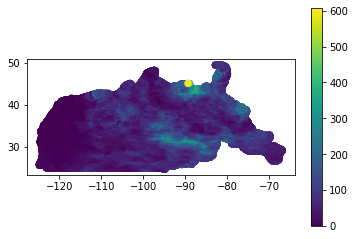

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ppt_gdf.plot(column="Precipitation", ax=ax, legend=True)

In [61]:
all_basin_geoms[2].bounds

(-70.404, 43.78152, -70.09572, 44.05648)